In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import fix_yahoo_finance as yf
from sklearn.preprocessing import MinMaxScaler
import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense , Dropout, Flatten, AveragePooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

Using TensorFlow backend.


In [2]:
##### Constants ####
frame_size = 60
label_size = 20
leave_last = 20
valid_size = 0.1
epoch = 30
ticker_name = "T"

In [3]:
data = yf.download(ticker_name, start="2011-01-01")

[*********************100%***********************]  1 of 1 downloaded


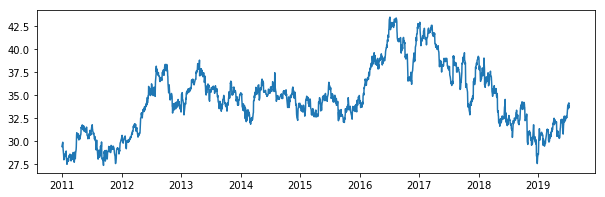

In [4]:
plt.figure(figsize=(10,3))
plt.plot(data.Open)
plt.show()

In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2.144000e+03
mean,34.561581,34.787626,34.315103,34.557477,27.551852,2.739584e+07
std,3.503441,3.512323,3.503001,3.512007,4.958041,1.392957e+07
min,27.300000,27.580000,26.800000,27.330000,17.300000,6.862400e+06
25%,32.217500,32.360000,31.957500,32.180000,24.797500,1.973230e+07
50%,34.490000,34.725000,34.240000,34.495000,27.040000,2.414410e+07
75%,36.700000,36.955000,36.475000,36.700000,31.650000,3.070295e+07
max,43.500000,43.890000,43.330000,43.470000,36.970000,1.950827e+08


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2144 entries, 2010-12-31 to 2019-07-10
Data columns (total 6 columns):
Open         2144 non-null float64
High         2144 non-null float64
Low          2144 non-null float64
Close        2144 non-null float64
Adj Close    2144 non-null float64
Volume       2144 non-null int64
dtypes: float64(5), int64(1)
memory usage: 117.2 KB


In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,29.36,29.53,29.29,29.38,18.33,15225500
2011-01-03,29.68,29.73,29.51,29.67,18.51,20582900
2011-01-04,29.80,29.91,29.65,29.88,18.64,20787200
2011-01-05,29.83,30.10,29.57,29.98,18.70,28147200
2011-01-06,29.57,29.61,28.70,29.15,18.45,40769500


In [8]:
the_safe_zone = np.zeros(len(data))

for i in range(len(data)):
    the_safe_zone[i] = float((data.iloc[i].Open + data.iloc[i].Close) / 2)

In [9]:
the_safe_zone

array([29.37 , 29.675, 29.84 , ..., 34.19 , 33.565, 33.75 ])

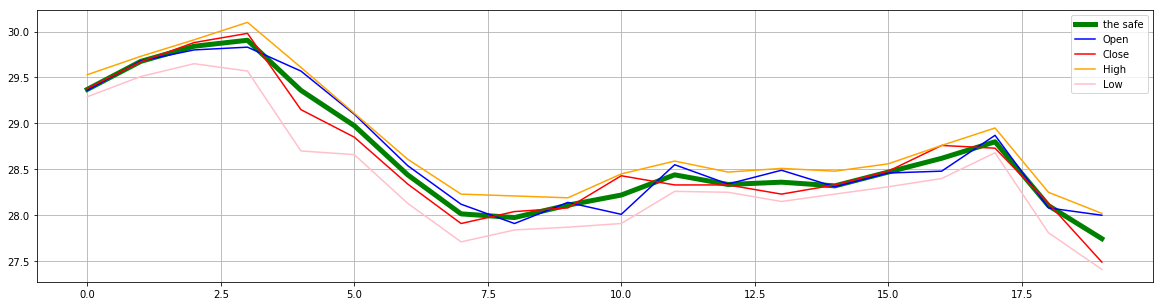

In [10]:
plt.figure(figsize=(20,5))
plt.plot(the_safe_zone[:20], label="the safe", c="green", linewidth=5)
plt.plot(data.Open.values[:20], label="Open", c="blue")
plt.plot(data.Close.values[:20], label="Close", c="red")
plt.plot(data.High.values[:20], label="High", c="orange")
plt.plot(data.Low.values[:20], label="Low", c="pink")
plt.grid()
plt.legend()
plt.show()

In [11]:
the_safe_zone = np.array(the_safe_zone)
the_safe_zone = the_safe_zone.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
safe_scaled = scaler.fit_transform(the_safe_zone)

In [12]:
extra = the_safe_zone[-170:]
the_safe_zone = the_safe_zone[:-170]

In [13]:
the_safe_zone.shape

(1974, 1)

In [14]:
train_x = []
train_y = []

for x in range(safe_scaled.shape[0]-((frame_size)+(label_size))):
    train_x.append(safe_scaled[x:(x+(frame_size))])
    train_y.append(safe_scaled[(x+(frame_size)):(x+(frame_size))+(label_size)])

In [15]:
print(train_x[100])

[[0.2197871 ]
 [0.22479649]
 [0.23794615]
 [0.25453976]
 [0.24076393]
 [0.22636193]
 [0.19849718]
 [0.18785222]
 [0.183469  ]
 [0.17658109]
 [0.17939887]
 [0.17845961]
 [0.18534753]
 [0.20726362]
 [0.19004383]
 [0.18002505]
 [0.20381966]
 [0.2100814 ]
 [0.2294928 ]
 [0.21853475]
 [0.20131497]
 [0.19724483]
 [0.20350657]
 [0.21884784]
 [0.23512837]
 [0.24702567]
 [0.25641828]
 [0.26487163]
 [0.24013776]
 [0.23700689]
 [0.22792736]
 [0.21289919]
 [0.20507201]
 [0.21195992]
 [0.20413275]
 [0.19098309]
 [0.16844083]
 [0.17470257]
 [0.17689418]
 [0.18252974]
 [0.17063244]
 [0.15685661]
 [0.154665  ]
 [0.15497808]
 [0.13400125]
 [0.10457107]
 [0.14621165]
 [0.11678147]
 [0.1183469 ]
 [0.09549155]
 [0.09611772]
 [0.03443957]
 [0.06105197]
 [0.05886036]
 [0.04852849]
 [0.07044458]
 [0.07514089]
 [0.07514089]
 [0.10018785]
 [0.07827176]]


In [16]:
train_y[80]

array([[0.17063244],
       [0.15685661],
       [0.154665  ],
       [0.15497808],
       [0.13400125],
       [0.10457107],
       [0.14621165],
       [0.11678147],
       [0.1183469 ],
       [0.09549155],
       [0.09611772],
       [0.03443957],
       [0.06105197],
       [0.05886036],
       [0.04852849],
       [0.07044458],
       [0.07514089],
       [0.07514089],
       [0.10018785],
       [0.07827176]])

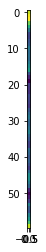

In [17]:
plt.imshow(train_x[1])
plt.show()

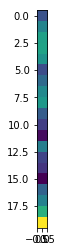

In [18]:
plt.imshow(train_y[1])
plt.show()

In [19]:
train_x = np.array(train_x)
train_y = np.array(train_y)

train_y = train_y.reshape(-1,label_size)

print(train_x.shape)
print(train_y.shape)

(2064, 60, 1)
(2064, 20)


In [20]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=valid_size, random_state = 42)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1857, 60, 1)
(1857, 20)
(207, 60, 1)
(207, 20)


In [21]:
mmaker_model = Sequential()

mmaker_model.add(Conv1D(128, 5, activation="tanh", padding="same", input_shape=(frame_size,1)))
mmaker_model.add(Conv1D(128, 5, activation="tanh", padding="same"))
mmaker_model.add(MaxPooling1D(2))
mmaker_model.add(Dropout(0.2))

mmaker_model.add(Conv1D(256, 3, activation="tanh", padding="same"))
mmaker_model.add(Conv1D(256, 3, activation="tanh", padding="same"))
mmaker_model.add(MaxPooling1D(2))
mmaker_model.add(Dropout(0.2))

mmaker_model.add(GlobalAveragePooling1D())

mmaker_model.add(Dense(32,activation="tanh"))
mmaker_model.add(Dense(24,activation="tanh"))

mmaker_model.add(Dense(label_size))

In [22]:
mmaker_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 256)           98560     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 256)           196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 256)           0         
__________

In [23]:
mmaker_model.compile(optimizer="adam",loss="mae")

In [24]:
history = mmaker_model.fit(train_x,train_y,batch_size=None,epochs=600,validation_data=(test_x,test_y))

Train on 1857 samples, validate on 207 samples
Epoch 1/600
1857/1857 [==============================] - 5s 3ms/step - loss: 0.1460 - val_loss: 0.1089
Epoch 2/600
1857/1857 [==============================] - 1s 373us/step - loss: 0.0958 - val_loss: 0.1093
Epoch 3/600
1857/1857 [==============================] - 1s 369us/step - loss: 0.0891 - val_loss: 0.0934
Epoch 4/600
1857/1857 [==============================] - 1s 370us/step - loss: 0.0825 - val_loss: 0.1130
Epoch 5/600
1857/1857 [==============================] - 1s 370us/step - loss: 0.0743 - val_loss: 0.0962
Epoch 6/600
1857/1857 [==============================] - 1s 370us/step - loss: 0.0695 - val_loss: 0.0721
Epoch 7/600
1857/1857 [==============================] - 1s 366us/step - loss: 0.0627 - val_loss: 0.0644
Epoch 8/600
1857/1857 [==============================] - 1s 366us/step - loss: 0.0583 - val_loss: 0.1086
Epoch 9/600
1857/1857 [==============================] - 1s 366us/step - loss: 0.0672 - val_loss: 0.0637
Epoch 10/6

Epoch 78/600
1857/1857 [==============================] - 1s 377us/step - loss: 0.0507 - val_loss: 0.0496
Epoch 79/600
1857/1857 [==============================] - 1s 393us/step - loss: 0.0518 - val_loss: 0.0601
Epoch 80/600
1857/1857 [==============================] - 1s 392us/step - loss: 0.0526 - val_loss: 0.0491
Epoch 81/600
1857/1857 [==============================] - 1s 374us/step - loss: 0.0505 - val_loss: 0.0481
Epoch 82/600
1857/1857 [==============================] - 1s 378us/step - loss: 0.0508 - val_loss: 0.0721
Epoch 83/600
1857/1857 [==============================] - 1s 385us/step - loss: 0.0529 - val_loss: 0.0538
Epoch 84/600
1857/1857 [==============================] - 1s 374us/step - loss: 0.0525 - val_loss: 0.0498
Epoch 85/600
1857/1857 [==============================] - 1s 383us/step - loss: 0.0505 - val_loss: 0.0487
Epoch 86/600
1857/1857 [==============================] - 1s 377us/step - loss: 0.0507 - val_loss: 0.0798
Epoch 87/600
1857/1857 [======================

1857/1857 [==============================] - 1s 385us/step - loss: 0.0495 - val_loss: 0.0559
Epoch 155/600
1857/1857 [==============================] - 1s 384us/step - loss: 0.0482 - val_loss: 0.0448
Epoch 156/600
1857/1857 [==============================] - 1s 386us/step - loss: 0.0495 - val_loss: 0.0451
Epoch 157/600
1857/1857 [==============================] - 1s 440us/step - loss: 0.0468 - val_loss: 0.0499
Epoch 158/600
1857/1857 [==============================] - 1s 385us/step - loss: 0.0454 - val_loss: 0.0525
Epoch 159/600
1857/1857 [==============================] - 1s 391us/step - loss: 0.0451 - val_loss: 0.0569
Epoch 160/600
1857/1857 [==============================] - 1s 387us/step - loss: 0.0489 - val_loss: 0.0493
Epoch 161/600
1857/1857 [==============================] - 1s 385us/step - loss: 0.0499 - val_loss: 0.0471
Epoch 162/600
1857/1857 [==============================] - 1s 385us/step - loss: 0.0466 - val_loss: 0.0499
Epoch 163/600
1857/1857 [==========================

1857/1857 [==============================] - ETA: 0s - loss: 0.042 - 1s 394us/step - loss: 0.0424 - val_loss: 0.0428
Epoch 231/600
1857/1857 [==============================] - 1s 392us/step - loss: 0.0420 - val_loss: 0.0488
Epoch 232/600
1857/1857 [==============================] - 1s 392us/step - loss: 0.0384 - val_loss: 0.0398
Epoch 233/600
1857/1857 [==============================] - 1s 400us/step - loss: 0.0389 - val_loss: 0.0400
Epoch 234/600
1857/1857 [==============================] - 1s 397us/step - loss: 0.0386 - val_loss: 0.0417
Epoch 235/600
1857/1857 [==============================] - 1s 399us/step - loss: 0.0381 - val_loss: 0.0554
Epoch 236/600
1857/1857 [==============================] - 1s 392us/step - loss: 0.0416 - val_loss: 0.0378
Epoch 237/600
1857/1857 [==============================] - 1s 404us/step - loss: 0.0395 - val_loss: 0.0399
Epoch 238/600
1857/1857 [==============================] - 1s 393us/step - loss: 0.0394 - val_loss: 0.0445
Epoch 239/600
1857/1857 [==

1857/1857 [==============================] - 1s 411us/step - loss: 0.0313 - val_loss: 0.0343
Epoch 307/600
1857/1857 [==============================] - 1s 411us/step - loss: 0.0322 - val_loss: 0.0336
Epoch 308/600
1857/1857 [==============================] - 1s 397us/step - loss: 0.0323 - val_loss: 0.0337
Epoch 309/600
1857/1857 [==============================] - 1s 405us/step - loss: 0.0319 - val_loss: 0.0389
Epoch 310/600
1857/1857 [==============================] - 1s 430us/step - loss: 0.0333 - val_loss: 0.0359
Epoch 311/600
1857/1857 [==============================] - 1s 427us/step - loss: 0.0324 - val_loss: 0.0396
Epoch 312/600
1857/1857 [==============================] - 1s 413us/step - loss: 0.0336 - val_loss: 0.0344
Epoch 313/600
1857/1857 [==============================] - 1s 405us/step - loss: 0.0319 - val_loss: 0.0339
Epoch 314/600
1857/1857 [==============================] - 1s 404us/step - loss: 0.0337 - val_loss: 0.0375
Epoch 315/600
1857/1857 [==========================

1857/1857 [==============================] - 1s 422us/step - loss: 0.0306 - val_loss: 0.0318
Epoch 383/600
1857/1857 [==============================] - 1s 419us/step - loss: 0.0291 - val_loss: 0.0316
Epoch 384/600
1857/1857 [==============================] - 1s 413us/step - loss: 0.0288 - val_loss: 0.0320
Epoch 385/600
1857/1857 [==============================] - 1s 421us/step - loss: 0.0289 - val_loss: 0.0326
Epoch 386/600
1857/1857 [==============================] - 1s 457us/step - loss: 0.0286 - val_loss: 0.0294
Epoch 387/600
1857/1857 [==============================] - 1s 448us/step - loss: 0.0276 - val_loss: 0.0292
Epoch 388/600
1857/1857 [==============================] - 1s 478us/step - loss: 0.0276 - val_loss: 0.0301
Epoch 389/600
1857/1857 [==============================] - 1s 455us/step - loss: 0.0283 - val_loss: 0.0304
Epoch 390/600
1857/1857 [==============================] - 1s 488us/step - loss: 0.0278 - val_loss: 0.0314
Epoch 391/600
1857/1857 [==========================

1857/1857 [==============================] - 1s 418us/step - loss: 0.0263 - val_loss: 0.0276
Epoch 459/600
1857/1857 [==============================] - 1s 431us/step - loss: 0.0265 - val_loss: 0.0278
Epoch 460/600
1857/1857 [==============================] - 1s 418us/step - loss: 0.0270 - val_loss: 0.0282
Epoch 461/600
1857/1857 [==============================] - 1s 411us/step - loss: 0.0261 - val_loss: 0.0285
Epoch 462/600
1857/1857 [==============================] - 1s 406us/step - loss: 0.0254 - val_loss: 0.0279
Epoch 463/600
1857/1857 [==============================] - 1s 418us/step - loss: 0.0257 - val_loss: 0.0276
Epoch 464/600
1857/1857 [==============================] - 1s 413us/step - loss: 0.0258 - val_loss: 0.0272
Epoch 465/600
1857/1857 [==============================] - 1s 421us/step - loss: 0.0254 - val_loss: 0.0288
Epoch 466/600
1857/1857 [==============================] - 1s 417us/step - loss: 0.0260 - val_loss: 0.0287
Epoch 467/600
1857/1857 [==========================

1857/1857 [==============================] - 1s 412us/step - loss: 0.0246 - val_loss: 0.0277
Epoch 535/600
1857/1857 [==============================] - 1s 407us/step - loss: 0.0255 - val_loss: 0.0265
Epoch 536/600
1857/1857 [==============================] - 1s 410us/step - loss: 0.0242 - val_loss: 0.0254
Epoch 537/600
1857/1857 [==============================] - 1s 412us/step - loss: 0.0239 - val_loss: 0.0264
Epoch 538/600
1857/1857 [==============================] - 1s 409us/step - loss: 0.0239 - val_loss: 0.0256
Epoch 539/600
1857/1857 [==============================] - 1s 430us/step - loss: 0.0245 - val_loss: 0.0268
Epoch 540/600
1857/1857 [==============================] - 1s 415us/step - loss: 0.0244 - val_loss: 0.0266
Epoch 541/600
1857/1857 [==============================] - 1s 413us/step - loss: 0.0244 - val_loss: 0.0276
Epoch 542/600
1857/1857 [==============================] - 1s 405us/step - loss: 0.0270 - val_loss: 0.0299
Epoch 543/600
1857/1857 [==========================

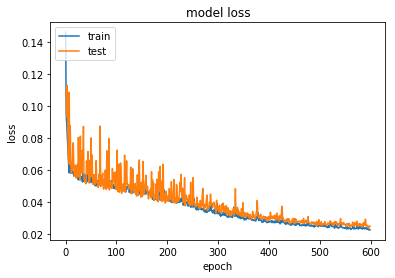

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
predictions = mmaker_model.predict(test_x)

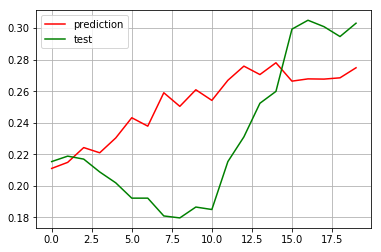

In [27]:
plt.plot(predictions[10], c="red", label="prediction")
plt.plot(test_y[10],c="green", label="test")
plt.grid()
plt.legend()
plt.show()

In [28]:
#for i in each 5:
#     array.append(prediction[i-5])...

In [29]:
r2_score(predictions,test_y)

0.9781301785345295

In [30]:
mmaker_model.save("good_model.h5")